# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import time
from datetime import date, datetime
import seaborn as sns
% matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
import classifier as clf
import classifier_functions as cf
import analysis_functions as af

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Understanding

So we have three datasets, let's go on and have a look at each of them

In [6]:
# Check shape
portfolio.shape

(10, 6)

In [7]:
# Small dataframe, so we can display all of it
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [8]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


**Findings**
* We have offer_type 'informational', for which we can not say for sure if a user responded to it, so we might as well
drop them;
* The company uses 4 channels of communication. The column contains dictionaries, so we'll probably need to unpack later;

In [9]:
# Check Transcript
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
# Check nulls
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [11]:
# Check event types
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

**Findings**
* Column 'value' contains dictionaries, we'll probably need to unpack later
* No nulls in our transaction dataset, very nice
* 4 types of events, we'll probably mostly use offer related ones

In [12]:
# Check time column stats
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [13]:
# Check value column dictionary keys
transcript['value'].apply(lambda x: ', '.join(x.keys())).value_counts()

amount              138953
offer id            134002
offer_id, reward     33579
Name: value, dtype: int64

In [14]:
transcript['keys'] = transcript['value'].apply(lambda x: ', '.join(x.keys()))

transcript.groupby(['event', 'keys']).count()

,,person,time,value
event,keys,,,
offer completed,"offer_id, reward",33579,33579,33579
offer received,offer id,76277,76277,76277
offer viewed,offer id,57725,57725,57725
transaction,amount,138953,138953,138953


In [15]:
transcript.drop('keys', axis = 1, inplace = True)

**Findings**
* Column 'value' has different spelling for different events, 'offer_id' for 'offer completed' and 'offer id' for others

offer received     0.455165
offer viewed       0.344460
offer completed    0.200375
Name: event, dtype: float64

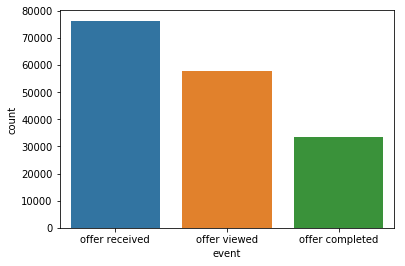

In [16]:
# Let's check the funnel offer received -> offer viewed -> offer completed
sns.countplot(transcript[transcript['event'] != 'transaction']['event'])

transcript[transcript['event'] != 'transaction']['event'].value_counts() / transcript[transcript['event'] != 'transaction']['event'].shape[0]


**Findings**
* The funnel ratios by stages are about 9-7-4, so about 78% of received offers get viewed and 44% get completed.
* In business terms, if our predictions help marketing team get more than 44% completed with the same budget spent, we've made progress

In [17]:
# Let's check max values of time for each event
transcript.groupby('event').max()['time']

event
offer completed    714
offer received     576
offer viewed       714
transaction        714
Name: time, dtype: int64

**Findings**
* Maximum 'time' for 'offer received' is 576, while for others it's 714. Which means we can make decisions for all of the offers received

In [18]:
# Chek profile
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [19]:
# Seems like we have nulls
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [20]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


**Findings**
* Looks like we have same number of nulls in 'gender' and 'income' columns
* Having three 118 year olds in the first 5 rows is a bit suspicious. 118 is the highest age so it's probably a default value

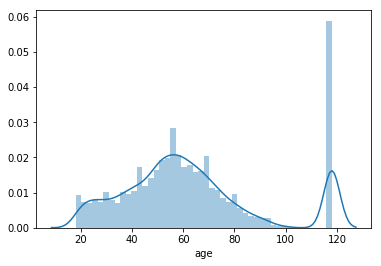

In [21]:
# Check age distribution
sns.distplot(profile['age'])

In [22]:
# Check number of age == 118
profile[profile['age'] == 118].shape[0]

2175

**Findings**
* Looks like we have same number of nulls in 'gender' and 'income' columns
* Maximum value of age is 118 and about 6% are of this age, it's most likely a default value for age when registering. They're basically nulls for age.
* We have the same number of gender/income nulls as 118 year olds, they're probably the same users

In [23]:
profile[profile['age'] == 118].isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [24]:
# Looks like they are the same rows

# Data Preparation

Function 'transform_data' unifies transformation steps we need to prepare data.

Here's a brief overview of the steps:
1. Clean portfolio and profile dataframes
   Mostly minor changes, such as changing data type of a column
2. Process transcript dataframe to discover which offers where responded to.
   From transcript dataset we get a new dataframe, where each row represents an offer received by a customer.
   If a user received an offer, then viewed it and then completed - we say that user responded to it.
3. Add amount spent and transaction count columns
4. Add prev_resp column, 1 if a user has previously responded to the same offer, 0 if hasn't
5. Split data to receive two dataframes, one with users with demographic data (df) and on without (df_nulls)
6. Get dummies for Gender column in df (df_nulls has nulls as Gender)
7. Return both dataframes

In [25]:
df, df_nulls = af.transform_data(portfolio, profile, transcript)

In [26]:
# Let's have a look at df_nulls responded column
df_nulls['responded'].value_counts()

0    5772
1     793
Name: responded, dtype: int64

In [27]:
# About 12% of values are 1 so there's a clear class imbalance. If we say that no user will respond to our offers,
# we'd get about 88% accuracy.

# Data Modeling

For modeling we train three classifiers with different parameter sets using GridSearchCV: Random Forests, Logistic Regression and KNeighbors. We do it for both df and df_nulls. For df_nulls, we might end up using none of them, depends whether the columns we have are enough to make decent predictions.

As for the metrics to evaluate our models, we'll use accuracy and F1.
We need accuracy because every True Positive is potential income and every False Negative is potential cost avoided.
We need F1 because we need both precision and recall to be decent. With high precision we make sure our investment will lead to high conversion, with high recall, we make sure we don't miss a lot of potential conversions.

In [28]:
# Create list of column names to scale, they're different for dataframes with and without demohraphic data
scale_cols = ['difficulty', 'duration', 'reward', 'age', 'income', 'days_registered', 'trans_cnt', 'avg_spent']
scale_cols_nulls = ['difficulty', 'duration', 'reward', 'days_registered', 'trans_cnt', 'avg_spent']

In [29]:
# First let's try dataset with demographic data
X_train, X_test, y_train, y_test, scaler = af.split_and_scale(df, scale_cols)

In [30]:
# Train and evaluate models with df
best_model = af.train_and_evaluate_models(X_train, y_train, X_test, y_test)

Started training...

rfc done.
time : 69.6331079006195
Params : {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 40}

log_reg done.
time : 77.49904537200928
Params : {'C': 2, 'solver': 'sag'}

knn done.
time : 155.3154332637787
Params : {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 10}



,F1,Accuracy
rfc,0.717275,0.764364
log_reg,0.634696,0.720725
knn,0.663932,0.736594


**Findings**
* Random Forest Classifier has the higheest F1 as well as the highest Accuracy, so no competition there. And both scores are above 0.7 so they're decent.

In [31]:
# Let's check non-demographic one

X_train_nulls, X_test_nulls, y_train_nulls, y_test_nulls, scale_nulls = af.split_and_scale(df_nulls, scale_cols_nulls)

In [32]:
# Train and evaluate models with df_nulls
best_model_nulls = af.train_and_evaluate_models(X_train_nulls, y_train_nulls, X_test_nulls,  y_test_nulls)

Started training...

rfc done.
time : 12.175261974334717
Params : {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 20}

log_reg done.
time : 59.84608864784241
Params : {'C': 2, 'solver': 'lbfgs'}

knn done.
time : 5.043091058731079
Params : {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 10}



,F1,Accuracy
rfc,0.447005,0.889248
log_reg,0.351421,0.884172
knn,0.349127,0.879557


**Findings**
* Accuracy looks good, but we could get 88% with just putting 0-s for every row
* F1 is really low for all of them, so the model doesn't really help that much

So for users without any demographic data, we can just assume they won't respond to such offers. The company might try to either get more information about these users or try different types of offers.

# Result Evaluation

As we see, Random Forest Classifier was the best, the classifier transforms data, fits RFC model and makes predictions whether a user will respond to an offer.

The classifier is fitted on Portfolio, Profile and Transcript datasets. To predict, it should be provided a path to a csv of person & offer_id pairs and a path to output predictions (person, offer_id, responded). If responded is 1 then user is likely to respond, if 0 then is not.

As the test set we use offers received in the last hour (576) of testing. Person & offer_id pairs are in xtest.csv and responded column is in y_test.csv. Also, the classifier contains a single line enabling it for testing.

*Note:*

If you want to use the classifier for non-testing purposes, remove or comment out the line in classifier.py:

#Uncomment if testing in jupyter notebooks
#transcript = transcript[(transcript['time'] != 576) | (transcript['event'] != 'offer')]

In [33]:
# Create recommender instance
clf = clf.Classifier()

# Fit
clf.fit('data/portfolio.json', 'data/profile.json', 'data/transcript.json')

# Predict
clf.predict('data/xtest.csv', 'data/preds.csv')

# Read
y_pred = pd.read_csv('data/preds.csv')
y_test = pd.read_csv('data/ytest.csv')

Importing Data
Transforming Data
Training RFC Model
Model is ready
Training time : 69.14430475234985
Params : {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 20}



In [34]:
# Set index to compare with y_test
y_pred = y_pred.set_index('Unnamed: 0').sort_index()

In [35]:
# Print scores
print('F1 score : {}'.format(f1_score(y_test['responded'], y_pred['responded'])))
print()
print('Accuracy score: {}:'.format(accuracy_score(y_test['responded'], y_pred['responded'])))
print()
print('Confusion matrix:')
print(confusion_matrix(y_test['responded'], y_pred['responded']))

F1 score : 0.6672648038964368

Accuracy score: 0.7448648648648649:

Confusion matrix:
[[4976 1538]
 [1058 2603]]


0.67 F1 score and 0.75 accuracy is decent but it's not great.

# Final thoughts

There probably are a number of additional steps we can take to make our scores better:
1. a deeper dive into EDA would be helpful to catch relationships
2. come up and engineer new features
3. handle nulls better, currently we simply put 0s for users without demographic data
4. maybe divide train and testing sets better
5. better error handling, runs without errors currently but it's not ready for production

Main challenges:
1. again, handling nulls and default values
2. feature engineering

Interesting parts:
1. super interesting to go through the whole end-to-end process
2. business problem is very realistic